# Example of making a lovely map of SIC with a track on it
note that you'll need to get ice_plot.py and readintoxr.py too



In [3]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import cartopy.crs as ccrs
import pandas as pd
import numpy.ma as ma
import h5py
import s3fs
import matplotlib.pyplot as plt
import netCDF4
import xarray as xr
import os
import ice_plot
import readintoxr



ModuleNotFoundError: No module named 'ice_plot'

#### Beam selection   
There are 6 beams to choose from in the ICESat-2 products (3 pairs of a strong and weak beam). The energy ratio between the weak and strong beams are  approximately 1:4 and are separated by 90 m in the across-track direction. The beam pairs are separated by ~3.3 km in the across-track direction, and the strong and weak beams are separated by ~2.5 km in the along-track direction.

#### chose a file to read, and set up some directories for where you've put stuff



In [1]:
ATL07file='processed_ATL07-01_20181130235806_09680101_001_01.h5'
ATL07file='processed_ATL07-01_20181206115828_10520101_001_01.h5'


DataFilePath='/home/jovyan/DATA/ChrisH_processed/'
fig_dir = '/home/jovyan/figures/'
nrt_dir = '/home/jovyan/NSIDC_0081/'

In [21]:
LocalFilePath=DataFilePath+ATL07file
ds1r = readintoxr.MakeDataSet(LocalFilePath, beam = 'gt1r')
ds1l = readintoxr.MakeDataSet(LocalFilePath, beam = 'gt1l')



Take a look at the dataset we made 

<xarray.Dataset>
Dimensions:       (segs: 346966)
Coordinates:
    lon           (segs) float64 -0.5842 -0.5842 -0.5842 ... -165.2 -165.2
    lat           (segs) float64 79.83 79.83 79.83 79.83 ... 71.08 71.08 71.08
    time          (segs) datetime64[ns] 2018-12-06T11:57:46 ... 2018-12-06T12:05:20
    delta_time    (segs) float64 2.933e+07 2.933e+07 ... 2.933e+07 2.933e+07
    lon360        (segs) float64 359.4 359.4 359.4 359.4 ... 194.8 194.8 194.8
  * segs          (segs) int64 0 1 2 3 4 ... 346961 346962 346963 346964 346965
Data variables:
    seg_dist      (segs) float64 8.92e+06 8.92e+06 ... 1.214e+07 1.214e+07
    height        (segs) float32 3.4028235e+38 3.4028235e+38 ... 0.20854685
    mss           (segs) float32 35.521385 35.521385 ... 0.009609258 0.009584308
    seg_length    (segs) float32 8106.915 4052.4314 ... 24.175938 46.304184
    quality_flag  (segs) int8 -1 -1 -1 -1 -1 -1 -1 -1 -1 ... 1 1 1 1 1 1 1 1 1
    isita_lead    (se

### Read in the obs, adjust the directories (see a few cells up) as needed

In [19]:
# Get recent observations NH only
ds_81 = xr.open_mfdataset(nrt_dir+'/*.nc', concat_dim='time', autoclose=True, parallel=True)
cd = ds1r.time[0].values  # get the first time in our track
cd = pd.to_datetime(cd).strftime('%Y-%m-%d') # convert time format to get rid of seconds
print('Get the Obs on this date ',cd, '/n/n')
# convert time format of obs to match
ds_81['time'] = pd.to_datetime(ds_81.time.values).strftime('%Y-%m-%d') 

# select the SIC for the day of our track
obs = ds_81.sic.sel(time=cd)
print(obs)


Get the Obs on this date  2018-12-06 /n/n
<xarray.DataArray 'sic' (y: 448, x: 304)>
dask.array<shape=(448, 304), dtype=float64, chunksize=(448, 304)>
Coordinates:
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
    hole_mask  (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    lat        (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon        (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm         (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym         (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    time       <U10 '2018-12-06'


In [11]:
### Map with the trac

In [2]:
cvar='seg_length'

cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_c.set_bad(color = 'lightgrey')

# can widen this or shift a bit 
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=1, nrows=2, Nplots=2, sizefcter=5, extent=central_extent, central_longitude=0)

i=0
obs_h = obs.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_c,
                      vmin=0, vmax=1)

da = ds1r[cvar]
track=axes[i].scatter(ds1r.lon, ds1r.lat, c=da, cmap='viridis', transform=ccrs.PlateCarree(),vmin=0, vmax=200)

f.colorbar(track, label=cvar, shrink=0.5, extend='both')

cbar_ax = f.add_axes([0.55, 0.325, 0.015, 0.35])
cbar = f.colorbar(obs_h, cax=cbar_ax, label='Sea Ice Concentration', orientation='vertical')


f_out = os.path.join(fig_dir,ATL07file+'_seg_lengths.png')
print(f_out)
plt.savefig(f_out,bbox_inches='tight', dpi=200)

NameError: name 'matplotlib' is not defined

### The rest is some gynmastics with xarray plotting and selecting

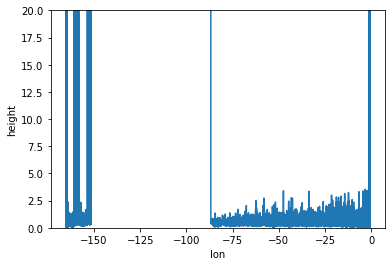

In [11]:
ds1r.height.plot(x='lon')
plt.ylim([0.,20.]);  # ugh there are some weird points

<xarray.DataArray 'height' (segs: 346966)>
array([     nan,      nan,      nan, ..., 0.133968, 0.131038, 0.208547],
      dtype=float32)
Coordinates:
    lon         (segs) float64 -0.5842 -0.5842 -0.5842 ... -165.2 -165.2 -165.2
    lat         (segs) float64 79.83 79.83 79.83 79.83 ... 71.08 71.08 71.08
    time        (segs) datetime64[ns] 2018-12-06T11:57:46 ... 2018-12-06T12:05:20
    delta_time  (segs) float64 2.933e+07 2.933e+07 ... 2.933e+07 2.933e+07
    lon360      (segs) float64 359.4 359.4 359.4 359.4 ... 194.8 194.8 194.8
  * segs        (segs) int64 0 1 2 3 4 5 ... 346961 346962 346963 346964 346965


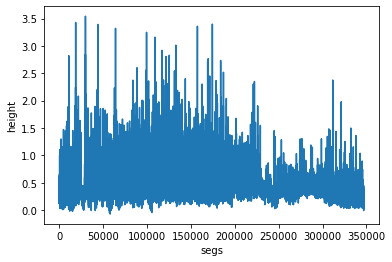

In [24]:
igood = ds1r.height.values<20.0  # make an array of T/F where the conditions is met
da_height_withnan = ds1r.height.where(igood)   # leaves nan where not true
print(da_height_withnan) # notice the segs are same total #
da_height_withnan.plot()

<xarray.DataArray 'height' (segs: 345815)>
array([0.229414, 0.269694, 0.270873, ..., 0.133968, 0.131038, 0.208547],
      dtype=float32)
Coordinates:
    lon         (segs) float64 -0.739 -0.7392 -0.7397 ... -165.2 -165.2 -165.2
    lat         (segs) float64 79.96 79.96 79.96 79.96 ... 71.08 71.08 71.08
    time        (segs) datetime64[ns] 2018-12-06T11:57:48 ... 2018-12-06T12:05:20
    delta_time  (segs) float64 2.933e+07 2.933e+07 ... 2.933e+07 2.933e+07
    lon360      (segs) float64 359.3 359.3 359.3 359.3 ... 194.8 194.8 194.8
  * segs        (segs) int64 66 67 68 69 77 ... 346962 346963 346964 346965


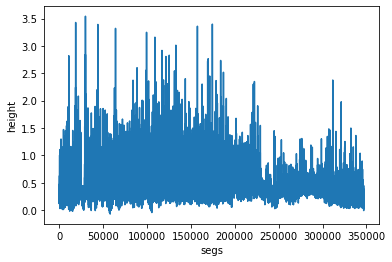

In [25]:
da_height_nonan = ds1r.height[igood]         # eliminates where not true makes dataarray
print(da_height_nonan) # notice there are fewer segs
da_height_nonan.plot()